# Turing Target Practice

## Model

In [1]:
# The statistical inference frame-work we will use
using Turing
using MCHMC
using Interpolations
using ForwardDiff
using LinearAlgebra

[ Info: Precompiling MCHMC [92da4d09-9da0-4f8a-8b31-da41ef0ab6ee]


In [2]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [3]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = linear_interpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = linear_interpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [4]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Normal(0.3, 0.1) # ~ Uniform(0.1, 0.9) 
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [5]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [6]:
target = TuringTarget(stat_model);

In [7]:
eps=0.5
L=sqrt(2)
settings = Settings(eps, L; integrator="MN")

Settings(Random.MersenneTwister(0), 0.1931833275037836, 0.5, 1.4142135623730951, "MN")

In [8]:
sampler = Sampler(settings, target);

In [9]:
init = MCHMC.Get_initial_conditions(sampler)
x, u, g, time = init

4-element Vector{Any}:
  [0.15856055895754276, 0.8600199625847514]
  [0.633972613807108, 0.7733554971309015]
  [-179.44544019535138, -87.01224597974786]
 0.0

In [10]:
MCHMC.Dynamics(sampler, init)

([0.25438513899210635, 0.7550295423872049], [0.20235886792717483, 0.9793114359442722], [-69.29533304341304, -132.65970696655413], 0.0)

In [11]:
MCHMC.Step(sampler, init)

(Any[[0.25438513899210635, 0.7550295423872049], [0.6003900401769028, 0.7997073212472029], [-69.29533304341304, -132.65970696655413], 0.0], [0.25438513899210635, 0.7550295423872049])

In [16]:
samples = Sample(sampler; num_steps=5000)

5000-element Vector{Vector{Float64}}:
 [0.25440386928026615, 0.7549906831343212]
 [0.23947460109188243, 0.7634630484925947]
 [0.24355253503352667, 0.7609179997636519]
 [0.24240653953937724, 0.7616147390782393]
 [0.24267053222512408, 0.76145309229208]
 [0.23658019115999224, 0.7650871769018128]
 [0.24424333261173278, 0.7602160918893462]
 [0.24194307074477842, 0.7616071609883359]
 [0.24326155164466115, 0.760795749664906]
 [0.24237798749414471, 0.7613338007620858]
 [0.24305509629483504, 0.7609184025238875]
 [0.2423964364775799, 0.7613199639690406]
 [0.24320681014258863, 0.760822548293958]
 ⋮
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]

## Plotting

In [13]:
Wms = [sample[1] for sample in samples]
s8s = [sample[2] for sample in samples]

5000-element Vector{Float64}:
 0.7549960404818021
 0.763589817606253
 0.760856355089871
 0.7616273531124683
 0.7612454048814915
 0.7621150338744489
 0.7611729265224284
 0.7616223613245467
 0.7612641606187616
 0.7615737018936404
 0.7612828865764141
 0.7617348828186961
 0.7612653497012187
 ⋮
 0.73022097016886
 0.7302079742888498
 0.7302197082388363
 0.7302010987199633
 0.7302106266106803
 0.7302386172415252
 0.7302053989323223
 0.7302251486701475
 0.7302021343508187
 0.7302219602813079
 0.7302085106630579
 0.7301908417958558

In [14]:
using PyPlot

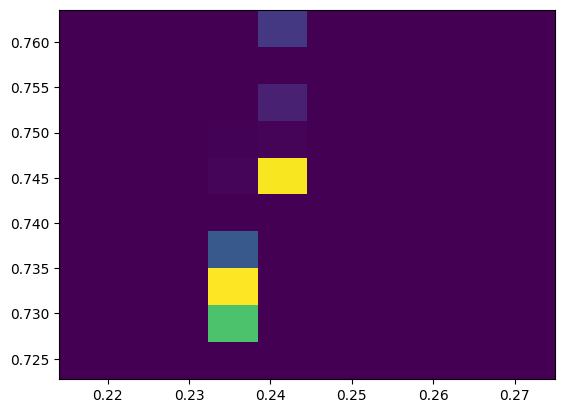

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.21404317827804112, 0.22013815922629051, 0.22623314017453994, 0.23232812112278933, 0.23842310207103873, 0.24451808301928812, 0.2506130639675376, 0.25670804491578697, 0.26280302586403637, 0.26889800681228576, 0.27499298776053516], [0.7227231905667169, 0.7268098532706705, 0.7308965159746241, 0.7349831786785777, 0.7390698413825313, 0.7431565040864849, 0.7472431667904386, 0.7513298294943922, 0.7554164921983457, 0.7595031549022994, 0.763589817606253], PyObject <matplotlib.collections.QuadMesh object at 0x7efc8133d640>)

In [15]:
plt.hist2d(Wms, s8s)